<a href="https://colab.research.google.com/github/anfins/K-Means/blob/main/Final_KMeans_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using KMeans Clustering to Identify Potential 2023 NBA Champions
## Jorden Anfinson
### 3/3/2023



Unsupervised learning can be described as a process in which patterns are discovered within unlabeled data. Unsupervised learning algorithms have become essential to any field involved in large scale data analysis.

A common unsupervised learning technique is called clustering. Clustering is the act of organizing segments of data into groups of data with similar characteristics. K-Means Clustering is a specific type of clustering algorithm that organizes data points into some 'k' number of clusters, while trying to minimize the distance between each point and its assigned cluster center. As with any clustering algorithm, K-Means can be leveraged to find patterns within data that normally wouldn't be readily apparent. This makes it a powerful tool in the analysis of sports data.

In this notebook, we use K-Means Clustering to identify teams that best fit the  statistical profile of past NBA Champions. We run K-Means 1000 times to find which currently playing teams most frequently cluster with past NBA champions, noting that the teams that most frequently do so are the most statistically similar to the past NBA champions.

In the end we identify the **Milwaukee Bucks** as the team that best fits the statistical profile of the past 13 NBA champions, and project that they will win the 2023 NBA Championship.

### Code Setup

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import cv2
import cv2 as cv
import pytest
import matplotlib.pyplot as plt
from sklearn import datasets   #only for the purposes of loading the iris dataset
import requests # request img from web
import shutil # save img locally
from PIL import Image
from google.colab import drive

from scipy import linalg as la



### Helper Functions

We use the functions below throughout the notebook to yield our results. We create the functions: "distance", "Kmeans", "KmeansAdditional", "appendAttributeInt" and "appendAttributeStr", "findK", and "analyzeClusters" to aid in the construction of the Kmeans algorithm.

"changeOverTime" is used to analyze how team averages have changed over time.


In [ ]:
def distance(x, y):
  """
  Computes the euclidean distance between two points x and y

  Inputs:
    X and Y are both arrays of some dimension. The arrays each represent some point
  Outputs:
    The distance between the points

  Additionally, this function is useful as it allows the distance between points to be calculated even when the number of features (dimension) at a given data point is greater than two
  """
  x = np.array(x) #converting the inputted arrays to numpy
  y= np.array(y)

  distance = 0
  if(len(x)!=len(y)): #if the number of dimensions for x != number of dimensions for y the distance formula will not work
    return

  for i in range(len(y)): #for each feature in the x and y compute the distance between them
    p =  ((y[i]-x[i])**2)
    distance = distance + p


  distance = distance ** 0.5

  return distance




In [ ]:
def Kmeans(k, dataIn):
  """
  This function will implement K-Means on inputted data

  Inputs:
    k : the number of clusters
    dataIn : the inputted data

  Outputs:
    centers: the locations of each cluster center
    error : the error of the overall clustering (how far each cluster is from each of it's points)
    numIterations : the amount of iterations it took for the clusters to reach their final location (the number of times the location of the cluster centers had to be changed)

  """
  data = np.array(dataIn)
  lengthData = data.shape[0] #creates an array of 0s [0,0,0,0...] with a size of the data
  dimData = data.shape[1]
  numIterations = 0
  error = 0


  #initialization of the random cluster centers

  min =  data.min(axis = 0)
  max = data.max(axis = 0)
  dim = np.shape(data)[1]
  centers = np.random.rand(k, dim) * (max - min) + min #sets the position of the random initial cluster centers
  oldCenters= np.random.rand(k, dim) * (max - min) + min

  pastDiff =0
  #when centers = oldcenters after the first iteration, the while loop below will stop (at this point the cluster centers will be in the mean position of all the points in the cluster)


  while(np.sum(np.sum(oldCenters - centers)) != pastDiff): #this while loop moves the cluster centers to their optimal locations
    numIterations = numIterations+ 1
    movement = np.sum(np.sum(oldCenters- centers))

    oldCenters = centers.copy()
    distances = np.ones((1,lengthData))*np.sum((data-centers[0,:])**2,axis=1) #calculates the distance of every cluster center to each datapoint
    for j in range(k-1):
      distances = np.append(distances, np.ones((1,lengthData))*np.sum((data-centers[j+1,:])**2, axis =1), axis = 0)


    cluster = distances.argmin(axis=0)
    cluster = np.transpose(cluster*np.ones((1,lengthData)))

    for j in range(k):
      thisCluster = np.where(cluster == j,1,0)
      if sum(thisCluster)>0:
        centers[j,:] = np.sum(data*thisCluster, axis = 0)/np.sum(thisCluster)



    notfirstpass = True


  for i in range(0, lengthData): #calculates how far each cluster is from the points it owns (each point has been assigned a cluster by this point, now we aggregate the distance between the clusters and their points)
    point = data[i]
    clusterPoint = centers[int(cluster[i])]
    point = np.array(point)
    clusterPoint = np.array(clusterPoint)
    error = error + distance(point, clusterPoint)


  mse = (1/(2*lengthData)) * error


  return centers, mse, numIterations



In [ ]:
def KmeansAdditional(k, dataIn):
  """
  This function will implement K-Means on inputted data and append each data point to their assigned cluster, returning an additional dataframe with this content
  As such, this function takes much longer to run than the normal Kmeans function above... and should only be used when one wants to analyze the contents of each cluster.
  Inputs:
    k : the number of clusters
    dataIn : the inputted data

  Outputs:
    centers: the locations of each cluster center
    error : the error of the overall clustering (how far each cluster is from each of it's points)
    numIterations : the amount of iterations it took for the clusters to reach their final location (the number of times the location of the cluster centers had to be changed)
    dataFf : the original inputted dataset with the cluster of each observation added on
  """
  originalColumns = dataIn.columns #getting the original columns for the inputted data, they will be reattached to a later output (DataDf)
  data = np.array(dataIn)


  lengthData = data.shape[0]
  dimData = data.shape[1]
  numIterations = 0
  error = 0


  #initialization of the random cluster centers

  min =  data.min(axis = 0)
  max = data.max(axis = 0)
  dim = np.shape(data)[1]
  centers = np.random.rand(k, dim) * (max - min) + min
  oldCenters= np.random.rand(k, dim) * (max - min) + min

  pastDiff =0
  #when centers = oldcenters after the first iteration, the while loop below will stop


  while(np.sum(np.sum(oldCenters - centers)) != pastDiff): #this while loop moves the cluster centers to their optimal locations
    numIterations = numIterations+ 1
    movement = np.sum(np.sum(oldCenters- centers))

    oldCenters = centers.copy()
    distances = np.ones((1,lengthData))*np.sum((data-centers[0,:])**2,axis=1) #calculates the distance of every cluster center to each datapoint
    for j in range(k-1):
      distances = np.append(distances, np.ones((1,lengthData))*np.sum((data-centers[j+1,:])**2, axis =1), axis = 0)


    cluster = distances.argmin(axis=0)
    cluster = np.transpose(cluster*np.ones((1,lengthData)))

    for j in range(k):
      thisCluster = np.where(cluster == j,1,0)
      if sum(thisCluster)>0:
        centers[j,:] = np.sum(data*thisCluster, axis = 0)/np.sum(thisCluster)



    notfirstpass = True


  dataDf =pd.DataFrame(data, columns = originalColumns) # making a copy of the original data

  dataDf["Cluster"] = 0 #creating a new column called "Cluster" and initializing the values within it to be 0

  for i in range(0, lengthData): #calculates how far each cluster is from the points it owns (each point has been assigned a cluster by this point, now we aggregate the distance between the clusters and their points)
    point = data[i] #getting each point in the data
    dataDf.at[i, "Cluster"] = cluster[i] #getting the cluster for each given point and assigning that value to the dataDf[row, Cluster]. Because of this, our original dataframe will now contain the cluster each datapoint was eventually assigned to
    clusterPoint = centers[int(cluster[i])]
    point = np.array(point)
    clusterPoint = np.array(clusterPoint)
    error = error + distance(point, clusterPoint)


  mse = (1/(2*lengthData)) * error


  return centers, mse, numIterations, dataDf



In [ ]:
 def findK(data, maxK):
  """
  Runs K-Means over a set of values for K, adding the error at each value of k to a list
  This function can be used to discover which value of K, or which number of clusters the data best clusters to

  Inputs:
    data : the data for which to run K-Means on
    maxK : the maximum value for k that K-Means will be run on
  Outputs:
    mseList: a list compiling the error present at each value for k
  """
  mseList = []
  for i in range(1, maxK+1): #gets the MSE for a range of K values by running K-Means for Various Ks and recording the results
    mse = Kmeans(i, data)[1]
    mseList.append([i, mse])

  return mseList



In [ ]:
def analyzeClusters(k, data, featurestoAnalyze):
  """
  This function runs KMeans on inputted data for a given value of K, and then returns a table containing the mean values for each feature within a given cluster


  """
  results = KmeansAdditional(k, data)[3]
  outputTable = []

  for i in range(0,k):

    subset = results.loc[results["Cluster"]==i]
    numinCluster = len(subset)
    clusterTable = [i, numinCluster]
    for feature in featurestoAnalyze:
          meanofFeature = subset[feature].mean()
          clusterTable.append(meanofFeature)



    outputTable.append(clusterTable)


  a = ["Cluster Number", "Number in Cluster"]
  for i in featurestoAnalyze:
    a.append(i)
  outputTable = pd.DataFrame(outputTable, columns = a)
  return outputTable
  #input data with clusters previously calculated using KMeans




In [ ]:
def appendAttributeInt(data, columnName, listToAppend):

  """
  This function will append a column with values of type int to an existing dataset

  Inputs:
    data : original dataset
    columnName : new column to create within data
    listToAppend : values to pass into the newly created column
  """
  outputDf = data

  outputDf[columnName] = 0

  for row,rowSeries in outputDf.iterrows():
    outputDf.at[row, columnName] = listToAppend[row]
  return outputDf

In [ ]:
def appendAttributeStr(data, columnName, listToAppend):

  """
  This function will append a column with values of type string to an existing dataset

  Inputs:
    data : original dataset
    columnName : new column to create within data
    listToAppend : values to pass into the newly created column
  """
  outputDf = data

  outputDf[columnName] = ""

  for row,rowSeries in outputDf.iterrows():
    outputDf.at[row, columnName] = listToAppend[row]
  return outputDf

In [ ]:
def changeOverTime(data, stat, startYear, endYear):
  """
  This function plots the change in a statistic over a given time period

  Inputs:
    data : the dataset
    stat : the statistic to measure the change of over time
    startYear : the year to start measuring the change of the statistic
    endYear : the year to stop measuring the change of the statistic
  Outputs:
    outputDf : a table containing the mean of stat for each season within the inputted time period
    columnName : the name of the column storing the mean of the statistic for each season (we return this so we can refer to the column name outside of the
    function when creating visuals later on)
  """
  outputDf = []
  for x in range(0,endYear-startYear + 1): #for every season in the inputted time period
    season = startYear + x
    yearData = dataCopy.loc[dataCopy["season"] == season] #filter the inputted dataset to only one season
    meanStat = yearData[stat].mean() #get the mean of the desired stat for that season
    outputDf.append([season, meanStat])
  columnName = "Mean" + stat
  outputDf = pd.DataFrame(outputDf, columns =["Year", columnName])
  return outputDf, columnName

## Data Source

The data used in this notebook stems from a kaggle dataset hosted at the following URL:  https://www.kaggle.com/datasets/sumitrodatta/nba-aba-baa-stats?select=Team+Stats+Per+Game.csv

It is also available in csv form at: https://raw.githubusercontent.com/anfins/K-Means/main/NBA_Stats.csv

 We utilize a dataset that contains the overall season stats of every team since the founding of the NBA in 1946. Containing 54 features in total, it contains over 40 continuous features such as "w" (wins), "l" (losses), "sos" (strength of schedule). The majority of these continuous features represent per-game statistics, such as "points per game" and "rebounds per game". Statistics such as these represent the season averages of a team.

The dataset also contains many descriptive features that detail the team's name, whether they made the playoffs, and whether they were an NBA Champion. A preview of the data used can be seen below. Additionally, a table describing the majority of the features within the dataset is enclosed in the appendix.


In [ ]:
url = "https://raw.githubusercontent.com/anfins/K-Means/main/NBA_Stats.csv" #I stored the data on my github and connected it to the notebook
data = pd.read_csv(url, sep = ",")
data.head()

,season,lg,team,abbreviation,playoffs,champion,g,w,l,sos,...,opp_ft_percent,opp_orb_per_game,opp_drb_per_game,opp_trb_per_game,opp_ast_per_game,opp_stl_per_game,opp_blk_per_game,opp_tov_per_game,opp_pf_per_game,opp_pts_per_game
0,2023,NBA,Atlanta Hawks,ATL,False,False,59.0,29.0,30.0,-0.22,...,0.803,11.0,34.6,45.6,25.6,7.4,5.0,14.5,19.8,116.7
1,2023,NBA,Boston Celtics,BOS,False,False,59.0,42.0,17.0,-0.35,...,0.776,9.4,34.1,43.6,22.9,6.6,3.9,12.6,19.5,111.7
2,2023,NBA,Brooklyn Nets,BRK,False,False,58.0,34.0,24.0,0.05,...,0.771,11.4,32.7,44.1,22.9,7.2,3.7,13.7,18.3,112.3
3,2023,NBA,Chicago Bulls,CHI,False,False,59.0,26.0,33.0,0.33,...,0.786,9.5,34.1,43.6,25.9,6.7,5.0,14.7,18.9,113.4
4,2023,NBA,Charlotte Hornets,CHO,False,False,60.0,17.0,43.0,0.38,...,0.794,11.1,35.6,46.7,26.6,6.6,5.9,15.0,20.6,118.9


In [ ]:
print(data.columns)

Index(['season', 'lg', 'team', 'abbreviation', 'playoffs', 'champion', 'g',
       'w', 'l', 'sos', 'pace', 'mp_per_game', 'fg_per_game', 'fga_per_game',
       'fg_percent', 'x3p_per_game', 'x3pa_per_game', 'x3p_percent',
       'x2p_per_game', 'x2pa_per_game', 'x2p_percent', 'ft_per_game',
       'fta_per_game', 'ft_percent', 'orb_per_game', 'drb_per_game',
       'trb_per_game', 'ast_per_game', 'stl_per_game', 'blk_per_game',
       'tov_per_game', 'pf_per_game', 'pts_per_game', 'opp_fg_per_game',
       'opp_fga_per_game', 'opp_fg_percent', 'opp_x3p_per_game',
       'opp_x3pa_per_game', 'opp_x3p_percent', 'opp_x2p_per_game',
       'opp_x2pa_per_game', 'opp_x2p_percent', 'opp_ft_per_game',
       'opp_fta_per_game', 'opp_ft_percent', 'opp_orb_per_game',
       'opp_drb_per_game', 'opp_trb_per_game', 'opp_ast_per_game',
       'opp_stl_per_game', 'opp_blk_per_game', 'opp_tov_per_game',
       'opp_pf_per_game', 'opp_pts_per_game'],
      dtype='object')


Before clustering, any feature that is indicative of a team's success is removed. We are interested in how the data will cluster solely using the team's stats, not measures of their success such as wins, losses, or whether they won a championship. After making copies of each, we remove the following features: "w" (wins), "l" (losses), "g" (games), "playoffs", and "champion", as we do not want clustering to be affected by these values.


In [ ]:
data["championNum"] = 0
data["playoffNum"] = 0
for row, rowSeries in data.iterrows():
  if rowSeries["champion"] == True:
    data.at[row, "championNum"] = 1
  if rowSeries["playoffs"] == True:
    data.at[row, "playoffNum"] = 1


In [ ]:
data = data.loc[data["team"]!= "League Average"] #we do not want to include the league average levels within our clustering
data = data.dropna().reset_index(drop=True) #dropping any rows that may contain NAs as they will mess up the KMeans algorithm and cause errors if included, also resetting indices to avoid missing index values later on
dataCopy = data

In [ ]:
#first drop all the columns that do not contain discrete/continouous data
#using non-continuous or discrete data in Kmeans would throw errors, as the distance formula won't work on non numeric data
refined = data.drop(["season", "lg", "team", "abbreviation", "playoffs","champion"], axis =1 )

In [ ]:
championNum = [] #array's to store the data held in championNum and playoffNum for later use
playoffNum = []

for row,rowSeries in refined.iterrows():
  championNum.append(rowSeries["championNum"]) #appending the values in "championNum" and "playoffNum" for later use
  playoffNum.append(rowSeries["playoffNum"])
refined = refined.drop(["championNum", "playoffNum"], axis =1 )

In [ ]:
normalizedRefined=(refined-refined.mean())/refined.std()  #normalizing the data

## What is K-Means?


K-Means Clustering works by grouping values within a dataset in a way that minimizes the MSE of the data. It takes in one parameter: K, which is equal to the number of clusters that will be used to group the data.

While the algorithm can be initialized in many different ways, a common technique is to pick K number of random points throughout the data.

The algorithm then repeats a two step process:

*   Data points are grouped by the cluster center that they are closest to (the distance from the cluster center to each point is calculated using the Euclidean Distance Formula).
*   The cluster centers each move to the mean location of the same cluster's assigned data points. This location will be the point that minimizes the Mean Squared Error at the current iteration.

We can define the Mean Squared Error of the algorithm as the sum of the distances from each cluster center to the data points belonging to a given cluster, divided by the number of points in the data. The second step of the above process will cause each cluster center to incrementally move towards the location that results in the lowest possible MSE. This two-step process will repeat until a shift of any of the cluster centers won't reduce the MSE at all.

## Implementation


In the cells below, we repeatedly run K-Means to cluster the team data of NBA Champions and Playoff Teams from the past 13 seasons with the data of teams currently playing in the 2023 NBA Season. We do this see which of the currently active teams most frequently cluster with the past champions, in the hopes of identifying teams that could potentially win the NBA championship this year. Teams that frequently cluster with past champions better fit the profile of an NBA champion than teams that seldom cluster with past NBA champions (at least statistically).



### Data Setup

To start we create two subsets of our original data and combine them to create the data we will use for clustering.

The first dataset contains the data for teams currently playing in the 2023 season.


In [ ]:
currentTeams = dataCopy.loc[dataCopy["season"] == 2023] #selecting the data of teams actively playing in the 2023 season

In [ ]:
currentTeams.head(5)

,season,lg,team,abbreviation,playoffs,champion,g,w,l,sos,...,opp_drb_per_game,opp_trb_per_game,opp_ast_per_game,opp_stl_per_game,opp_blk_per_game,opp_tov_per_game,opp_pf_per_game,opp_pts_per_game,championNum,playoffNum
0,2023,NBA,Atlanta Hawks,ATL,False,False,59.0,29.0,30.0,-0.22,...,34.6,45.6,25.6,7.4,5.0,14.5,19.8,116.7,0,0
1,2023,NBA,Boston Celtics,BOS,False,False,59.0,42.0,17.0,-0.35,...,34.1,43.6,22.9,6.6,3.9,12.6,19.5,111.7,0,0
2,2023,NBA,Brooklyn Nets,BRK,False,False,58.0,34.0,24.0,0.05,...,32.7,44.1,22.9,7.2,3.7,13.7,18.3,112.3,0,0
3,2023,NBA,Chicago Bulls,CHI,False,False,59.0,26.0,33.0,0.33,...,34.1,43.6,25.9,6.7,5.0,14.7,18.9,113.4,0,0
4,2023,NBA,Charlotte Hornets,CHO,False,False,60.0,17.0,43.0,0.38,...,35.6,46.7,26.6,6.6,5.9,15.0,20.6,118.9,0,0


The second dataset contains the data for each team that played in the past 13 seasons (2010-2022). This dataset also naturally includes the past 13 NBA champions.


Although we are mainly interested in how currently playing teams cluster with past champions, we include the data of other teams to introduce more noise.

If teams more frequently cluster with more teams that did not win the championship in their respective season rather than past NBA Champions, they do not closely fit the statistical profile of an NBA champion. One could say these teams are not likely to win an NBA championship.


In [ ]:
pastTeams = dataCopy.loc[(dataCopy["season"]>=2010) & (dataCopy["season"] < 2023)] #selecting the data of playoff teams from 2010-2022

In [ ]:
pastTeams.tail(5)

,season,lg,team,abbreviation,playoffs,champion,g,w,l,sos,...,opp_drb_per_game,opp_trb_per_game,opp_ast_per_game,opp_stl_per_game,opp_blk_per_game,opp_tov_per_game,opp_pf_per_game,opp_pts_per_game,championNum,playoffNum
415,2010,NBA,Sacramento Kings,SAC,False,False,82.0,25.0,57.0,0.30,...,31.0,42.0,20.5,7.1,5.7,13.7,20.1,104.4,0,0
416,2010,NBA,San Antonio Spurs,SAS,True,False,82.0,50.0,32.0,-0.02,...,29.6,39.5,19.2,6.9,5.1,12.6,20.4,96.3,0,1
417,2010,NBA,Toronto Raptors,TOR,False,False,82.0,40.0,42.0,-0.05,...,29.9,41.3,23.0,7.1,4.4,12.7,21.1,105.9,0,0
418,2010,NBA,Utah Jazz,UTA,True,False,82.0,53.0,29.0,-0.01,...,29.0,39.2,19.9,7.7,5.4,15.1,22.2,98.9,0,1
419,2010,NBA,Washington Wizards,WAS,False,False,82.0,26.0,56.0,0.06,...,30.9,42.3,21.6,6.9,5.1,13.6,20.5,101.0,0,0


We only select data from the past 13 seasons so as to avoid clustering by time. Basketball has changed over time, and the statistics reflect this. The plot below shows how the average number of 3 pointers made per game has changed over the past 40 seasons.

Text(0.5, 1.0, 'Number of Threes Made Per Game by Season')

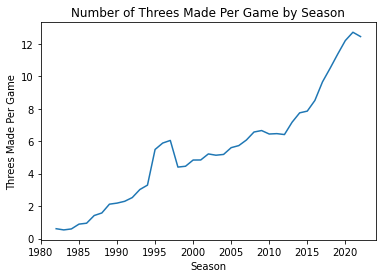

In [ ]:
changeIn3s, colName = changeOverTime(dataCopy, "x3p_per_game", 1982,2022)
plt.plot(changeIn3s["Year"], changeIn3s[colName])
plt.xlabel("Season")
plt.ylabel("Threes Made Per Game")
plt.title("Number of Threes Made Per Game by Season")

The chart below represents the change in average Pace (possessions per game) over the past 40 seasons.

Text(0.5, 1.0, 'Average Number of Possessions Per Game by Season')

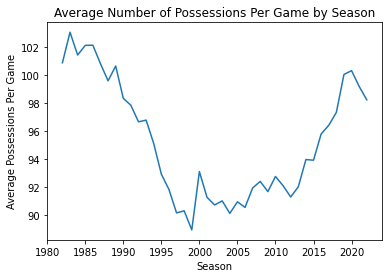

In [ ]:
changeIn3s, colName = changeOverTime(dataCopy, "pace", 1982,2022)
plt.plot(changeIn3s["Year"], changeIn3s[colName])
plt.xlabel("Season")
plt.ylabel("Average Possessions Per Game")
plt.title("Average Number of Possessions Per Game by Season")

The charts above clearly show that averages for certain stats have changed over time.

While there still likely will be some clustering due to time, by restricting the data to represent the past 13 seasons, we reduce the potential that the data will be clustered by time rather than pure statistics.




We finally combine the two datasets, one consisting of active teams, and the other of teams from 2010-2022, to create the dataset we run K-Means on.





In [ ]:
refinedCurrent =  pd.concat([currentTeams, pastTeams], axis=0)


### Data Cleaning

As we hope to eventually see whether the data will naturally cluster teams that make the playoffs or become champions together and away from teams that do not, we drop any column that indicates whether a team made the playoffs or won a championship. We only want teams to cluster based on their statistical profile, not by their success.

We also remove any feature that is an aggregate statistic (wins, losses, and games played). We do this as teams currently playing in the 2023 season will not have played the same number of games as teams from years past and who already completed their season.

In [ ]:
championNumCurrent = []
playoffNumCurrent = []
seasonCurrent = []
teamCurrent= []
for row,rowSeries in refinedCurrent.iterrows():
  championNumCurrent.append(rowSeries["championNum"])
  playoffNumCurrent.append(rowSeries["playoffNum"])
  teamCurrent.append(rowSeries["team"])
  seasonCurrent.append(rowSeries["season"])
refinedCurrent = refinedCurrent.drop(["season", "lg", "team", "abbreviation", "playoffs","champion", "g", "w","l"], axis =1 )
refinedCurrent = refinedCurrent.drop(["championNum", "playoffNum"], axis =1 )


### Standardization

The table below indicates that many features within the dataset are of differing ranges. If data such as this were to be fed directly into the KMeans algorithm, features of larger scales, in our case features such as "pace" and "fga__per_game", would affect the overall clustering more than other features.


In [ ]:
refinedCurrent.describe()

,sos,pace,mp_per_game,fg_per_game,fga_per_game,fg_percent,x3p_per_game,x3pa_per_game,x3p_percent,x2p_per_game,...,opp_ft_percent,opp_orb_per_game,opp_drb_per_game,opp_trb_per_game,opp_ast_per_game,opp_stl_per_game,opp_blk_per_game,opp_tov_per_game,opp_pf_per_game,opp_pts_per_game
count,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,...,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000
mean,-0.001381,95.887381,241.708571,39.014286,85.115952,0.458329,9.404048,26.325238,0.356090,29.613095,...,0.764436,10.536190,32.779762,43.316905,22.966190,7.606667,4.863571,14.266429,20.196667,105.007619
std,0.372156,3.726139,0.890053,2.272642,3.659944,0.016085,2.800743,7.496977,0.018081,2.073781,...,0.015325,0.903282,2.086322,2.085677,2.022109,0.681535,0.707702,1.182829,1.292641,6.963628
min,-0.930000,87.700000,240.000000,33.200000,75.800000,0.408000,3.800000,11.300000,0.295000,23.100000,...,0.725000,8.000000,28.200000,38.100000,17.800000,5.900000,3.000000,11.300000,16.200000,88.200000
25%,-0.272500,92.900000,241.100000,37.400000,82.400000,0.447000,7.075000,19.900000,0.344750,28.275000,...,0.754750,9.900000,31.400000,41.975000,21.475000,7.200000,4.400000,13.400000,19.375000,99.800000
50%,0.000000,96.000000,241.700000,38.800000,85.200000,0.458000,9.350000,26.050000,0.355000,29.750000,...,0.764000,10.600000,32.900000,43.350000,23.200000,7.550000,4.800000,14.200000,20.150000,104.850000
75%,0.280000,98.700000,242.225000,40.700000,87.900000,0.469000,11.500000,32.125000,0.368000,31.025000,...,0.775000,11.100000,34.225000,44.700000,24.525000,8.000000,5.300000,15.100000,21.000000,110.400000
max,0.960000,105.100000,244.900000,44.700000,94.400000,0.512000,16.700000,45.400000,0.416000,35.300000,...,0.808000,13.400000,37.700000,49.000000,27.100000,9.900000,6.900000,18.300000,24.300000,122.600000


To remedy this, we standardize the data, which involves subtracting the mean value of the feature from each point, and then dividing by the standard deviation of the feature.

In [ ]:
normalizedCurrent = (refinedCurrent-refinedCurrent.mean())/refinedCurrent.std()  #standardizing the data

In [ ]:
normalizedCurrent.head(1)

,sos,pace,mp_per_game,fg_per_game,fga_per_game,fg_percent,x3p_per_game,x3pa_per_game,x3p_percent,x2p_per_game,...,opp_ft_percent,opp_orb_per_game,opp_drb_per_game,opp_trb_per_game,opp_ast_per_game,opp_stl_per_game,opp_blk_per_game,opp_tov_per_game,opp_pf_per_game,opp_pts_per_game
0,-0.587439,1.264746,0.439781,2.237798,1.962885,1.223001,0.391308,0.543521,-0.502768,1.874308,...,2.516446,0.513471,0.872463,1.094654,1.302506,-0.303237,0.192777,0.197468,-0.306865,1.679065


In [ ]:
normalizedCurrent.describe()

,sos,pace,mp_per_game,fg_per_game,fga_per_game,fg_percent,x3p_per_game,x3pa_per_game,x3p_percent,x2p_per_game,...,opp_ft_percent,opp_orb_per_game,opp_drb_per_game,opp_trb_per_game,opp_ast_per_game,opp_stl_per_game,opp_blk_per_game,opp_tov_per_game,opp_pf_per_game,opp_pts_per_game
count,4.200000e+02,4.200000e+02,4.200000e+02,4.200000e+02,4.200000e+02,4.200000e+02,4.200000e+02,4.200000e+02,4.200000e+02,4.200000e+02,...,4.200000e+02,4.200000e+02,4.200000e+02,4.200000e+02,4.200000e+02,4.200000e+02,4.200000e+02,4.200000e+02,4.200000e+02,4.200000e+02
mean,-2.008975e-17,2.706829e-16,-1.938767e-14,7.443781e-16,-3.248195e-15,8.797196e-16,1.353415e-16,4.736952e-16,3.637302e-16,4.398598e-16,...,5.210647e-15,-2.639159e-15,-1.353415e-16,-1.962451e-15,-1.827110e-15,-1.023520e-15,1.353415e-16,1.471839e-15,-1.844028e-15,3.383537e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.495240e+00,-2.197283e+00,-1.919630e+00,-2.558381e+00,-2.545381e+00,-3.129001e+00,-2.000915e+00,-2.004173e+00,-3.378736e+00,-3.140686e+00,...,-2.573309e+00,-2.807750e+00,-2.195137e+00,-2.501301e+00,-2.554852e+00,-2.504151e+00,-2.633273e+00,-2.507909e+00,-3.091862e+00,-2.413630e+00
25%,-7.285088e-01,-8.017363e-01,-6.837477e-01,-7.103123e-01,-7.420749e-01,-7.043138e-01,-8.315821e-01,-8.570439e-01,-6.272086e-01,-6.452442e-01,...,-6.320245e-01,-7.043098e-01,-6.613370e-01,-6.433906e-01,-7.374431e-01,-5.966922e-01,-6.550379e-01,-7.325052e-01,-6.356498e-01,-7.478313e-01
50%,3.710680e-03,3.022406e-02,-9.630249e-03,-9.428924e-02,2.296418e-02,-2.042776e-02,-1.929760e-02,-3.671321e-02,-6.031105e-02,6.601698e-02,...,-2.843178e-02,7.064185e-02,5.763161e-02,1.586787e-02,1.156266e-01,-8.314564e-02,-8.982801e-02,-5.616074e-02,-3.610181e-02,-2.263462e-02
75%,7.560829e-01,7.548347e-01,5.802225e-01,7.417420e-01,7.606805e-01,6.634583e-01,7.483559e-01,7.736134e-01,6.586810e-01,6.808360e-01,...,6.893542e-01,6.241788e-01,6.927205e-01,6.631398e-01,7.708829e-01,5.771285e-01,6.166844e-01,7.047268e-01,6.214669e-01,7.743637e-01
max,2.583273e+00,2.472430e+00,3.585663e+00,2.501808e+00,2.536664e+00,3.336831e+00,2.605006e+00,2.544327e+00,3.313421e+00,2.742288e+00,...,2.842712e+00,3.170449e+00,2.358331e+00,2.724821e+00,2.044306e+00,3.364953e+00,2.877524e+00,3.410105e+00,3.174381e+00,2.526324e+00


## Using K-Means to Identify Potential Future NBA Champions

We use the elbow graph below to determine the optimal value of K that could be used in our clustering. We do so by utilizing the "findK" function, which runs K-Means over a range of K values and returns the MSE of the data for each value of K.

In [ ]:
errorDf= findK(normalizedCurrent, 20)
errorDf = pd.DataFrame(errorDf, columns = ["k", "MSE"])


The graph below indicates that a K value of 4 could be used to cluster the data well, even though it is not exactly an elbow point.

Text(0, 0.5, 'MSE')

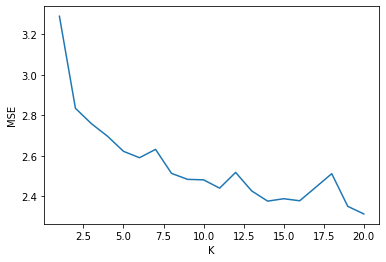

In [ ]:
plt.plot(errorDf["k"], errorDf["MSE"])
plt.xlabel("K")
plt.ylabel("MSE")

After identifying the optimal value of K, we run K-Means 1000 times on our clustering dataset using a K of 4.

K-Means is initialized by positioning K random cluster centers throughout the data. Because of this, the final location of cluster centers will often times vary. By running the algorithm 1000 times, we reduce the randomness caused by the random initialization of cluster centers and can better quantify how similar each active team is to past NBA Champions.


After each iteration of K-Means we record how many past NBA Champions each active team clustered with. We use a dictionary to do so, using each active team's name as a key and the total number of champions each team clustered with across all 1000 iterations of K-Means as a value.


For example, if 4 former NBA Champions clustered with the Milwaukee Bucks during the first iteration of K-Means, and 5 in the second, the value in the dictionary assigned to Milwaukee after two iterations of K-Means would be 9, and we would repeat this procedure 998 more times.

The function "evals" below, recreates the idea described above.

In [ ]:
def eval(k, numberofTimesRun):

  """
  This function runs KMeans a certain number of times, and for each iteration of KMeans the function adds the number of past champions each 2023 team was clustered with.
  For example, if 5 previous NBA champions were in cluster 2, and the 2023 Memphis Grizzles were also in cluster 2, the value for Memphis would be increased by 5.
  The end result is a table that details how many past champions each team was clustered with throughout all the iterations.


  Inputs:
    k: the number of clusters formed in each iteration of K-Means
    numberofTimesRun: the number of times running K-Means

  Outputs:
    A table detailing how many past champions each team was clustered with throughout all the iterations.

  """
  output = {} #dictionary that will end up containing keys of team names and values of the total number of past champions the team clustered with over all iterations

  firstRun = True
  for i in range(numberofTimesRun):
    results = KmeansAdditional(k, normalizedCurrent)[3] #running K-Means and returning the original dataset with attached clusters "numberofTimesRun" # of times

    results = pd.DataFrame(results)

    #reappending descriptive data to the dataframe that was passed to KmeansAdditional
    together = appendAttributeInt(results, "championNum", championNumCurrent)
    together = appendAttributeInt(together, "playoffNum", playoffNumCurrent)

    together = appendAttributeStr(results, "season", seasonCurrent)
    together = appendAttributeStr(together, "team", teamCurrent)


    for row, rowSeries in together.iterrows(): #this for loop goes through each team (row in together) and finds how many past champions the team is clustered with
      team = ""
      cluster= 0
      if(rowSeries["season"] == 2023):
        team = rowSeries["team"]
        cluster = rowSeries["Cluster"]
        champions = together.loc[together["championNum"] == 1]

        numberofChampsClusterd = 0 #the number of champions the team was clustered with
        for i in champions["Cluster"]:

          if(i == cluster):
            numberofChampsClusterd = numberofChampsClusterd +1

        if(firstRun == True):
          output[team] = numberofChampsClusterd
        if(firstRun != True):
          output[team] += numberofChampsClusterd
    firstRun = False
  return output



*small warning, the eval function will take nearly 5 minutes or so to run*

In [ ]:
x = eval(4, 1000)


In [ ]:
#recreating x as a list called data instead of a dictionary
data =[]
for team in x:
  data.append([team, x[team]])
finalDf = pd.DataFrame(data, columns = ["Team", "Number of Former Champions Clustered With"])
finalDf = finalDf.sort_values(by = ["Number of Former Champions Clustered With"], ascending = False).reset_index(drop=True)

In [ ]:
finalDf

,Team,Number of Former Champions Clustered With
0,Milwaukee Bucks,10572
1,Brooklyn Nets,10172
2,Boston Celtics,9992
3,Washington Wizards,9980
4,Denver Nuggets,9924
5,Chicago Bulls,9732
6,Philadelphia 76ers,9656
7,Los Angeles Clippers,9372
8,Cleveland Cavaliers,9368
9,Miami Heat,8604



After using the "evals" function to run K-Means 1000 times on our clustering dataset, we can see that the Milwaukee Bucks clustered with the most former NBA Champions: 10572, across all 1000 iterations of K-Means. Because Milwaukee clustered with the most former NBA Champions, we can say they are the most statistically similar to the past 13 NBA Champions out of the active teams.

 The Brooklyn Nets, Boston Celtics, Washington Wizards, Denver Nuggets. Chicago Bulls, Philadelphia 76ers, Los Angeles Clippers, Cleveland Cavaliers, and Miami Heat clustered with the next highest numbers of former NBA champions over all iterations of K-Means. Interestingly, each of these teams (minus Washington and Chicago) are within the top eight teams in their respective conferences.

In [ ]:
top10 = finalDf.iloc[0:10]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, 'Milwaukee Bucks'),
  Text(1, 0, 'Brooklyn Nets'),
  Text(2, 0, 'Boston Celtics'),
  Text(3, 0, 'Washington Wizards'),
  Text(4, 0, 'Denver Nuggets'),
  Text(5, 0, 'Chicago Bulls'),
  Text(6, 0, 'Philadelphia 76ers'),
  Text(7, 0, 'Los Angeles Clippers'),
  Text(8, 0, 'Cleveland Cavaliers'),
  Text(9, 0, 'Miami Heat'),
  Text(10, 0, 'New York Knicks'),
  Text(11, 0, 'Dallas Mavericks'),
  Text(12, 0, 'Phoenix Suns'),
  Text(13, 0, 'Sacramento Kings'),
  Text(14, 0, 'Portland Trail Blazers'),
  Text(15, 0, 'Golden State Warriors'),
  Text(16, 0, 'Orlando Magic'),
  Text(17, 0, 'Los Angeles Lakers'),
  Text(18, 0, 'New Orleans Pelicans'),
  Text(19, 0, 'Atlanta Hawks'),
  Text(20, 0, 'Memphis Grizzlies'),
  Text(21, 0, 'Utah Jazz'),
  Text(22, 0, 'Toronto Raptors'),
  Text(23, 0, 'Minnesota Timberwolves'),
  Text(24, 0, 'Oklahoma City Thun

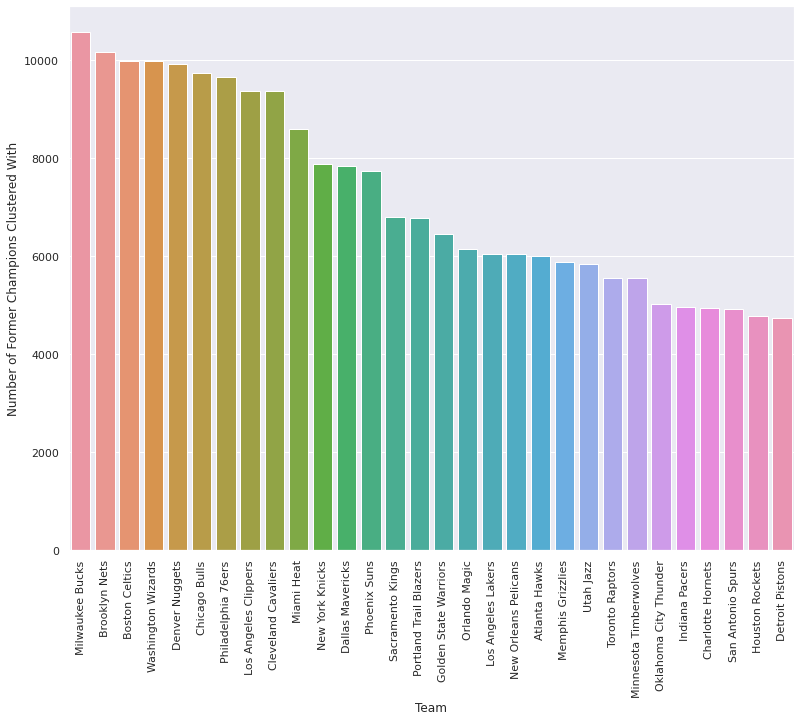

In [ ]:

bar = sns.barplot(data=finalDf, x="Team", y="Number of Former Champions Clustered With")
sns.set(rc={'figure.figsize':(13, 10)})


plt.xticks(rotation=90)



## Conclusion


We showed that K-Means can be used to identify potential future NBA champions by counting the number of former champions each active team clusters with over repeated runs of the K-Means algorithm. In doing so, we identified the teams that are the most statistically similar to past NBA Champions.

We identified the Milwaukee Bucks as the most statistically similar team to the past 13 NBA Champions, and predict that Milwaukee will go on to win their second NBA title in three seasons.